In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from IPython.display import display, HTML

In [4]:
df = pd.concat([pd.read_csv(f,encoding= 'cp1252',delimiter=';') for f in glob.glob('./data/*.txt')], ignore_index = True)


In [8]:
df.describe()

,CODIGO_SECCION,MES,ANYO,NUM_APTOS,NUM_APTOS_1conv,NUM_APTOS_2conv,NUM_APTOS_3o4conv,NUM_APTOS_5_o_mas_conv,NUM_NO_APTOS
count,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000
mean,2.524879,6.481265,2018.467508,3.113780,1.891486,0.643870,0.437609,0.140815,2.620282
std,3.568686,3.589821,0.498944,4.501126,2.968654,1.206378,1.047882,0.516985,5.141090
min,1.000000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,2018.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,10.000000,2019.000000,4.000000,2.000000,1.000000,1.000000,0.000000,3.000000
max,48.000000,12.000000,2019.000000,375.000000,216.000000,94.000000,85.000000,45.000000,590.000000


In [11]:
df['aptos/total'] = df['NUM_APTOS']/(df['NUM_APTOS'] + df['NUM_NO_APTOS'])

In [16]:
df.columns

Index(['DESC_PROVINCIA', 'CENTRO_EXAMEN', 'CODIGO_AUTOESCUELA',
       'NOMBRE_AUTOESCUELA', 'CODIGO_SECCION', 'MES', 'ANYO', 'TIPO_EXAMEN',
       'NOMBRE_PERMISO', 'NUM_APTOS', 'NUM_APTOS_1conv', 'NUM_APTOS_2conv',
       'NUM_APTOS_3o4conv', 'NUM_APTOS_5_o_mas_conv', 'NUM_NO_APTOS',
       'aptos/total'],
      dtype='object')

In [39]:
#df[df['NOMBRE_PERMISO'] == 'B']
df.drop(df[df.NOMBRE_PERMISO != 'B  '].index, inplace=True)
df.drop(df[df.TIPO_EXAMEN == 'PRUEBA TEÓRICA'].index, inplace=True)

In [40]:
df.sort_values(by = ['aptos/total','NUM_APTOS'],ascending = False)

,DESC_PROVINCIA,CENTRO_EXAMEN,CODIGO_AUTOESCUELA,NOMBRE_AUTOESCUELA,CODIGO_SECCION,MES,ANYO,TIPO_EXAMEN,NOMBRE_PERMISO,NUM_APTOS,NUM_APTOS_1conv,NUM_APTOS_2conv,NUM_APTOS_3o4conv,NUM_APTOS_5_o_mas_conv,NUM_NO_APTOS,aptos/total
266825,Lleida,Lleida,L 0109,CAPELL,1,2,2019,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,15,11,3,0,1,0,1.0
189191,Asturias,Oviedo,O 0325,MIERES,5,8,2018,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,12,12,0,0,0,0,1.0
335795,Granada,Baza,GR0391,CLARA,1,12,2018,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,12,4,1,4,3,0,1.0
18944,León,León,LE0182,CENTRO,2,3,2019,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,11,4,1,6,0,0,1.0
113634,Valencia/València,Valencia/València ( municipio sin especificar),V 0083,EL CID,6,7,2018,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,11,8,3,0,0,0,1.0
294743,Ceuta,Ceuta,CE0010,AVENIDA,1,11,2018,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,11,4,3,4,0,0,1.0
52804,Gipuzkoa,Beasain,SS0172,IRUIN AUTOESKOLA,1,5,2019,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,10,7,2,1,0,0,1.0
94726,Huelva,Huelva,H 0134,A E ILIPLA,2,7,2018,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,10,5,2,2,1,0,1.0
124670,Barcelona,Vilafranca del Penedès,B 1188,LA GELTRU,4,1,2019,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,10,6,0,4,0,0,1.0
134511,Lleida,"Pobla de Segur, La",L 0021,PALLARS,2,1,2019,PRUEBA CONDUCCIÓN Y CIRCULACIÓN,B,10,6,3,1,0,0,1.0


### Comparación por meses  autoescuela SAN CRISTOBAL con ABRIL

In [173]:
san_cristobal = df[df['NOMBRE_AUTOESCUELA'] == 'SAN CRISTOBAL']
abril = df[df['NOMBRE_AUTOESCUELA'] == 'ABRIL']
print("\t San Cristobal \t\t Abril")
agg_cristobal = monthly(san_cristobal)
agg_abril = monthly(abril)
pd.merge(agg_cristobal,agg_abril, on = 'MES')

	 San Cristobal 		 Abril


,aptos/total_x,NUM_APTOS_x,aptos/total_y,NUM_APTOS_y
MES,,,,
1,0.497205,141,0.477525,99
2,0.381418,144,0.359807,121
3,0.500091,158,0.402075,136
4,0.511357,167,0.282282,24
5,0.487760,188,0.397066,117
7,0.458973,169,0.402385,92
8,0.541174,129,0.355556,16
9,0.469281,199,0.354241,70
10,0.456593,184,0.393548,83


In [169]:
def monthly(df, imprimir = False):
    monthly_ratio = df[['aptos/total','MES']]
    monthly_aptos = df[['NUM_APTOS','MES']]
    year = pd.merge(monthly_ratio.groupby('MES').mean(),monthly_aptos.groupby('MES').sum(), on = 'MES')
    if (imprimir):
        display(year)
    return year

In [ ]:
df[df['NOMBRE_AUTOESCUELA'] == 'ABRIL'].sum()

In [165]:
provinces = df.iloc[:,[0,9,15]]
res_provinces = pd.merge(
        df[['DESC_PROVINCIA','NUM_APTOS']].groupby('DESC_PROVINCIA').sum(),
        df[['DESC_PROVINCIA','aptos/total']].groupby('DESC_PROVINCIA').mean(),
        on = 'DESC_PROVINCIA')

### Provincias con mayor probabilidad de aprobar el práctico

In [145]:
res_sorted = res_provinces.sort_values(by = ['aptos/total','NUM_APTOS'],ascending = False)
res_sorted.head()

,NUM_APTOS,aptos/total
DESC_PROVINCIA,,
Lugo,2377,0.596643
Cuenca,4783,0.558810
Toledo,10130,0.553633
Lleida,4264,0.545673
Castellón/Castelló,5462,0.534281


In [157]:
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = geocoders.Nominatim(user_agent="juanluisrto")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.01)


In [155]:
res_sorted.reset_index(level=0, inplace=True)

In [174]:
res_sorted['spain'] = res_sorted['DESC_PROVINCIA'] + ", España"
res_sorted['location'] = res_sorted['spain'].apply(geocode)
res_sorted['latitude'] = res_sorted['location'].apply(lambda x: x.latitude)
res_sorted['longitude'] = res_sorted['location'].apply(lambda x: x.longitude)
res_sorted.drop(columns=['spain','location'])

,DESC_PROVINCIA,NUM_APTOS,aptos/total,latitude,longitude
0,Lugo,2377,0.596643,43.046225,-7.473992
1,Cuenca,4783,0.558810,40.068116,-2.134824
2,Toledo,10130,0.553633,39.856068,-4.023957
3,Lleida,4264,0.545673,41.614761,0.626784
4,Castellón/Castelló,5462,0.534281,39.986035,-0.037735
5,Ceuta,714,0.515080,35.888361,-5.304138
6,Pontevedra,7552,0.511188,42.607517,-8.471494
7,Ciudad Real,4691,0.504801,38.959751,-3.882828
8,Araba/Álava,2618,0.504257,42.844317,-2.682203
9,Gipuzkoa,5317,0.503531,43.144528,-2.203796


In [175]:
import plotly.plotly as py
import plotly.graph_objs as go

In [176]:
res_sorted.head()

,DESC_PROVINCIA,NUM_APTOS,aptos/total,location,spain,latitude,longitude
0,Lugo,2377,0.596643,"(Lugo, Galicia, España, (43.0462247, -7.4739921))","Lugo, España",43.046225,-7.473992
1,Cuenca,4783,0.558810,"(Cuenca, Castilla-La Mancha, España, (40.06811...","Cuenca, España",40.068116,-2.134824
2,Toledo,10130,0.553633,"(Toledo, Castilla-La Mancha, España, (39.85606...","Toledo, España",39.856068,-4.023957
3,Lleida,4264,0.545673,"(Lleida, Segrià, Lleida, CAT, España, (41.6147...","Lleida, España",41.614761,0.626784
4,Castellón/Castelló,5462,0.534281,"(Castelló de la Plana, la Plana Alta, Castelló...","Castellón/Castelló, España",39.986035,-0.037735


In [192]:
dims = res_sorted[['NUM_APTOS','aptos/total']]
ratio = dims.max()

In [193]:
res_sorted['aptos/total']/ratio['aptos/total']

0     1.000000
1     0.936590
2     0.927914
3     0.914573
4     0.895479
5     0.863298
6     0.856774
7     0.846070
8     0.845157
9     0.843941
10    0.841946
11    0.816825
12    0.812243
13    0.809748
14    0.807663
15    0.806165
16    0.805846
17    0.803881
18    0.803210
19    0.801329
20    0.800917
21    0.800719
22    0.799105
23    0.796434
24    0.795885
25    0.794234
26    0.790484
27    0.786505
28    0.785836
29    0.784476
30    0.781141
31    0.778031
32    0.773844
33    0.769478
34    0.752655
35    0.749162
36    0.748900
37    0.748764
38    0.724484
39    0.724343
40    0.719587
41    0.716792
42    0.704824
43    0.697443
44    0.686349
45    0.679220
46    0.661572
47    0.658749
48    0.635953
49    0.625985
50    0.589621
51    0.578080
52    0.394253
Name: aptos/total, dtype: float64

In [203]:
import geopandas as gpd
import descartes

In [199]:
fp = "./es_10km.shx"
map_df = gpd.read_file(fp)
print(type(map_df))

<class 'geopandas.geodataframe.GeoDataFrame'>


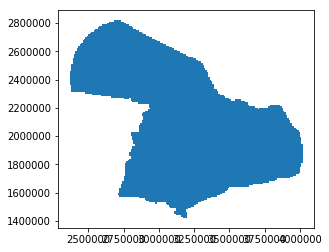

In [204]:
map_df.plot()